In [ ]:
import os
import random
import shutil

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from thop import profile

import time
from datetime import timedelta

In [ ]:
# Set the seed for Python's random module, numpy, snd torch
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

# Ensure that CUDA operations are deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(17)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
len(os.listdir('data/train/MSS')), len(os.listdir('data/val/MSS')), len(os.listdir('data/test/MSS'))

(37505, 4600, 4600)

In [ ]:
len(os.listdir('data/train/MSI')), len(os.listdir('data/val/MSI')), len(os.listdir('data/test/MSI'))

(37505, 4600, 4600)

In [ ]:
folders = [
    "data/train/MSS", "data/val/MSS", "data/test/MSS",
    "data/train/MSI", "data/val/MSI", "data/test/MSI"
]

# Transform to convert image to tensor [0, 1] range
transform = transforms.ToTensor()

# To accumulate sums
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_pixels = 0

for folder in folders:
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if not filename.lower().endswith('.png'):
            continue  # Skip non-image files

        img = Image.open(filepath).convert("RGB")  # Ensure 3 channels
        tensor = transform(img)  # Shape: [C, H, W]

        num_pixels += tensor.shape[1] * tensor.shape[2]
        channel_sum += tensor.sum(dim=[1, 2])
        channel_squared_sum += (tensor ** 2).sum(dim=[1, 2])

# Mean and std calculation
mean = channel_sum / num_pixels
std = (channel_squared_sum / num_pixels - mean ** 2).sqrt()

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Mean: [0.7262989282608032, 0.5129403471946716, 0.6925135254859924]
Std: [0.15637946128845215, 0.20308662950992584, 0.14605671167373657]


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.726, 0.513, 0.693], std=[0.156, 0.203, 0.146])
])

In [ ]:
# Load the datasets
train_data = datasets.ImageFolder(root='data/train', transform=transform)
val_data = datasets.ImageFolder(root='data/val', transform=transform)
test_data = datasets.ImageFolder(root='data/test', transform=transform)

In [ ]:
print(train_data.class_to_idx)

{'MSI': 0, 'MSS': 1}


In [ ]:
batch_size = 32

In [ ]:
# DataLoader for batch processing
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

## Functions

In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0

    total_start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print("\n" + f"Epoch {epoch + 1}/{num_epochs}" + "\n" + "_" * 10)

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float()) # Squeeze output, labels to float

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track performance
            running_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int().squeeze()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time  # Calculate epoch duration

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%, Time: {timedelta(seconds=epoch_time)}")

        # Evaluate on validation set after each epoch
        val_loss, val_accuracy = evaluate_val(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        torch.cuda.empty_cache()

        # Record training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Evaluate on validation set and record metrics
        val_loss, val_accuracy = evaluate_val(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
          print("Early stopping triggered")
          break

    total_end_time = time.time()  # Record end time of the entire training process
    total_time = total_end_time - total_start_time  # Calculate total training duration
    print(f"Training completed in {timedelta(seconds= total_time)}")

    # Plot the metrics
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate the model on the validation set
def evaluate_val(model, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int().squeeze()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
# Function to evaluate the model
def evaluate_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            predicted = (probs > 0.5).int().squeeze()  # Predictions based on probability threshold

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels


In [ ]:
def evaluate_model_and_plot_roc(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # To store prediction probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()  # Get probabilities, squeeze for consistency

            all_preds.extend((probs > 0.5).int().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

        accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
        print(f"Test Accuracy: {accuracy:.2f}%")

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to visualize some predictions
def visualize_predictions(model, test_loader, num_images=6):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    outputs = model(images)
    probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    predicted = (probs > 0.5).int().squeeze()  # Predictions based on probability threshold

    # Plot images and their predicted labels
    fig = plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = fig.add_subplot(2, 3, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
        img = np.clip(img * np.array([0.156, 0.203, 0.146]) + np.array([0.726, 0.513, 0.693]), 0, 1)# Unnormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {test_data.classes[predicted[i]]}, True: {test_data.classes[labels[i]]}")
        ax.axis('off')
    plt.show()


In [ ]:
def count_parameters(model):
    input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Shape (batch_size, channels, height, width)

    # Calculate FLOPs and parameters
    flops, params = profile(model, inputs=(input_tensor,))

    # Calculate the number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Print the results
    print(f"FLOPs: {flops / 1e9:.2f} Giga FLOPs")  # FLOPs in billions
    print(f"Total Number of Parameters: {total_params / 1e6:.2f} million")  # Parameters in millions
    print(f"Trainable Number of Parameters: {trainable_params / 1e6:.2f} million")  # Trainable params in millions

In [ ]:
def visualize_list(model, image_paths, transform, num_images=6):
    model.eval()
    class_names = ['MSI', 'MSS']  # Map class index to name

    # Prepare the images
    images = []
    for image_path in image_paths[:num_images]:  # Limit to num_images
        img = Image.open(image_path).convert('RGB')
        img = transform(img)
        images.append(img)

    images = torch.stack(images).to(device)

    # Get predictions
    outputs = model(images)
    probs = torch.sigmoid(outputs)
    predicted = (probs > 0.5).int().squeeze()

    # Plot images and their predicted labels
    fig = plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = fig.add_subplot(2, 3, i+1)

        # Load and resize image for visualization
        img = Image.open(image_paths[i]).convert('RGB')
        img_np = np.array(img.resize((224, 224))) / 255.0

        # Inferred true label from folder name
        true_label = os.path.basename(os.path.dirname(image_paths[i]))
        pred_label = class_names[predicted[i].item()]

        ax.imshow(img_np)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        # If class_idx not provided, take the output prediction
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass
        output[0][0].backward(retain_graph=True)

        # Compute weights: global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted sum of activations
        gradcam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        gradcam_map = F.relu(gradcam_map)

        # Normalize the Grad-CAM heatmap
        gradcam_map = F.interpolate(gradcam_map, size=(224, 224), mode='bilinear', align_corners=False)
        gradcam_map = gradcam_map.squeeze().cpu().numpy()
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min() + 1e-8)

        return gradcam_map

In [ ]:
def visualize_gradcam(model, gradcam, image_path, transform):
    """Visualizes Grad-CAM heatmap on an image with overlay colouring."""

    # Load image and preprocess
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get Grad-CAM heatmap (assumed to be 2D numpy array)
    heatmap = gradcam(input_tensor)

    # Normalize heatmap to [0, 1]
    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)  # avoid divide-by-zero

    # Convert image to numpy
    img_np = np.array(img.resize((224, 224))) / 255.0

    # Apply colormap to heatmap
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)  # convert to RGB
    heatmap_color = np.float32(heatmap_color) / 255.0

    # Blend heatmap with image
    overlayed = 0.5 * heatmap_color + 0.5 * img_np
    overlayed = np.clip(overlayed, 0, 1)

    # Plot
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 3, 1)
    plt.title('Original Image', fontsize=8)
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap', fontsize=8)
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlayed', fontsize=8)
    plt.imshow(overlayed)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, path="model_checkpoint.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path)
    print(f"Checkpoint saved to: {path}")

In [ ]:
def load_checkpoint(model, optimizer=None, path="model_checkpoint.pth", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {path}")
    print(f"Resuming from epoch {epoch} with loss {loss}")

    return model, optimizer, epoch, loss

In [ ]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

## CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation, Batch Normalization, and pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 28 * 28)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
#Initialize CNN
cnn = CNN()

# Move model to the GPU if available
cnn = cnn.to(device)


In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=0.0001, weight_decay= 0.0001)

In [ ]:
torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm=1)

tensor(0.)


Epoch 1/25
__________
Epoch [1/25], Loss: 0.7197, Accuracy: 53.29%, Time: 0:04:24.597282
Validation Loss: 0.6759, Validation Accuracy: 58.08%

Epoch 2/25
__________
Epoch [2/25], Loss: 0.6709, Accuracy: 58.83%, Time: 0:04:11.496742
Validation Loss: 0.6584, Validation Accuracy: 60.90%

Epoch 3/25
__________
Epoch [3/25], Loss: 0.6406, Accuracy: 63.82%, Time: 0:04:27.061523
Validation Loss: 0.6515, Validation Accuracy: 60.52%

Epoch 4/25
__________
Epoch [4/25], Loss: 0.6080, Accuracy: 67.19%, Time: 0:03:04.523006
Validation Loss: 0.5883, Validation Accuracy: 69.03%

Epoch 5/25
__________
Epoch [5/25], Loss: 0.5773, Accuracy: 69.68%, Time: 0:03:04.238545
Validation Loss: 0.5716, Validation Accuracy: 70.68%

Epoch 6/25
__________
Epoch [6/25], Loss: 0.5462, Accuracy: 72.33%, Time: 0:03:04.851042
Validation Loss: 0.5519, Validation Accuracy: 71.72%

Epoch 7/25
__________
Epoch [7/25], Loss: 0.5083, Accuracy: 75.14%, Time: 0:03:04.572468
Validation Loss: 0.5224, Validation Accuracy: 74.11%

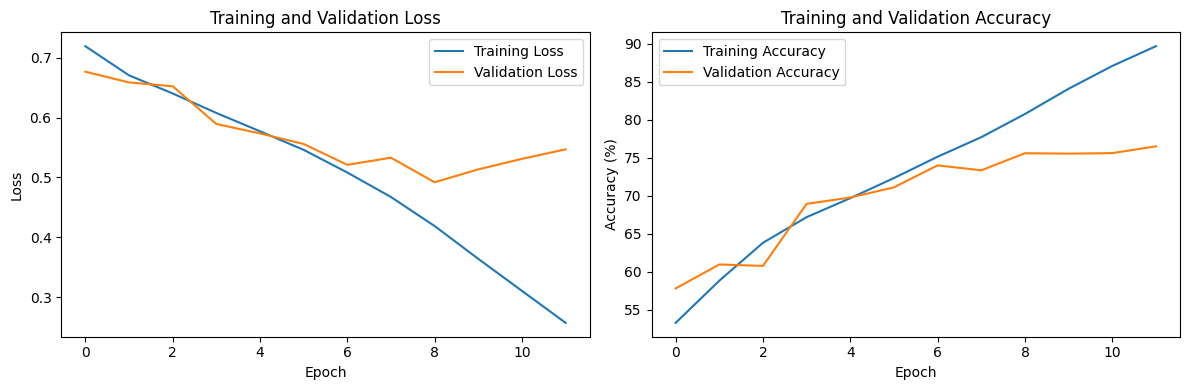

In [ ]:
# Train the model
train_model(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=25)

### Evaluations - CNN

In [ ]:
# Evaluate the model
y_pred1, y_true1 = evaluate_test(cnn, test_loader)

Test Accuracy: 75.72%



Classification Report:
              precision    recall  f1-score   support

         MSI       0.77      0.74      0.75      4600
         MSS       0.75      0.78      0.76      4600

    accuracy                           0.76      9200
   macro avg       0.76      0.76      0.76      9200
weighted avg       0.76      0.76      0.76      9200



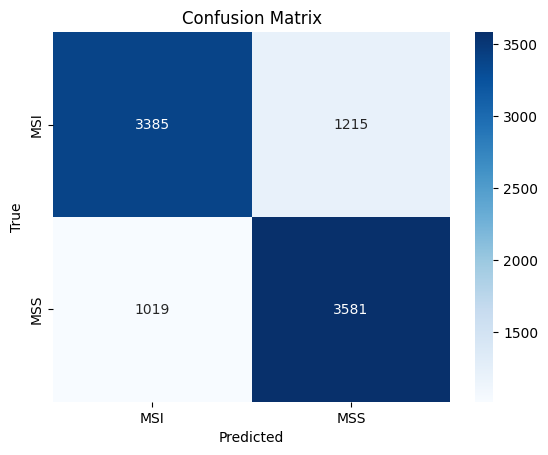

In [ ]:
# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true1, y_pred1, target_names=test_data.classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true1, y_pred1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print (f'PPV= {3385/(3385 + 1019)}')

PPV= 0.7686194368755677


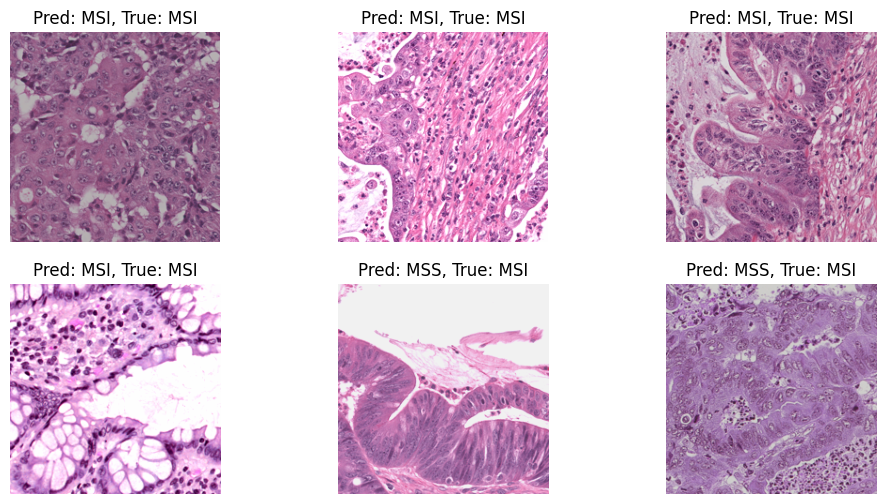

In [ ]:
# Visualize predictions
visualize_predictions(cnn, test_loader)

Test Accuracy: 76.23%


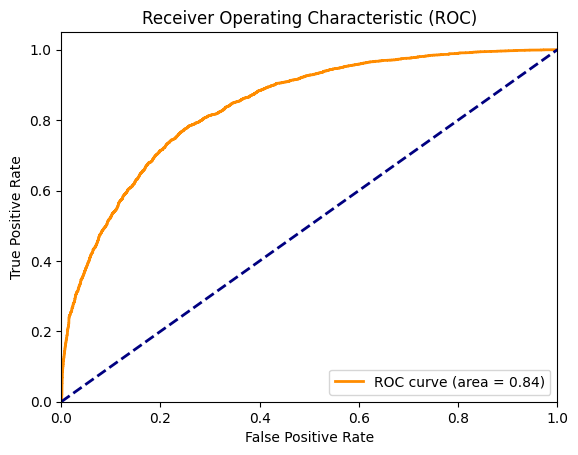

In [ ]:
evaluate_model_and_plot_roc(cnn, test_loader)

In [ ]:
count_parameters(cnn)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 0.57 Giga FLOPs
Total Number of Parameters: 51.47 million
Trainable Number of Parameters: 51.47 million


In [ ]:
epoch_cnn = 12
loss_cnn = 0.2567

In [ ]:
save_checkpoint(cnn, optimizer, epoch_cnn, loss_cnn, path="checkpoint_cnn.pth")

Checkpoint saved to: checkpoint_cnn.pth


### Model GradCAM - CNN

In [ ]:
image_path = 'data/test/MSI/blk-TCTTFAFCPHDK-TCGA-QG-A5Z2-01Z-00-DX1.png'

In [ ]:
gradcam_cnn= GradCAM(cnn, cnn.conv3)

In [ ]:
image_list = ['data/test/MSI/blk-TCTTFAFCPHDK-TCGA-QG-A5Z2-01Z-00-DX1.png',
              'data/test/MSI/blk-TGGWDGHQHWGS-TCGA-QG-A5Z2-01Z-00-DX2.png',
              'data/test/MSI/blk-THSPPPPFNKIL-TCGA-G4-6304-01Z-00-DX1.png',
              'data/test/MSS/blk-YGFVGPWSQWEI-TCGA-AZ-4682-01Z-00-DX1.png',
              'data/test/MSS/blk-YGKVAIKLCEGH-TCGA-4N-A93T-01Z-00-DX1.png',
              'data/test/MSS/blk-YIKMYYLPHAFQ-TCGA-AF-A56L-01Z-00-DX1.png']

C:\Users\olubo\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


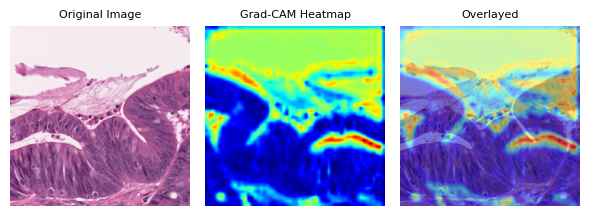

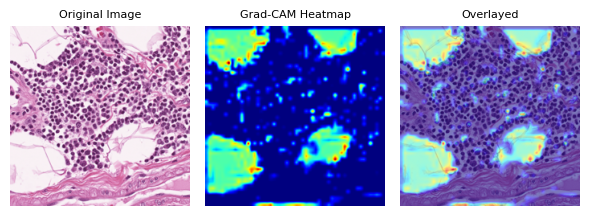

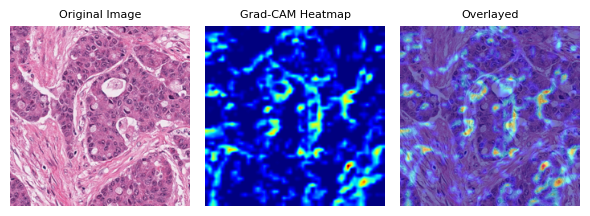

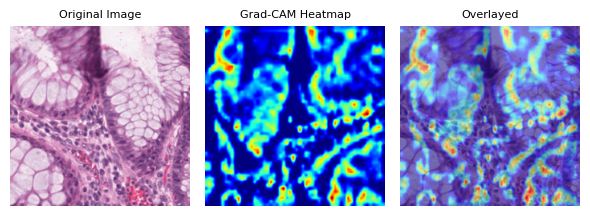

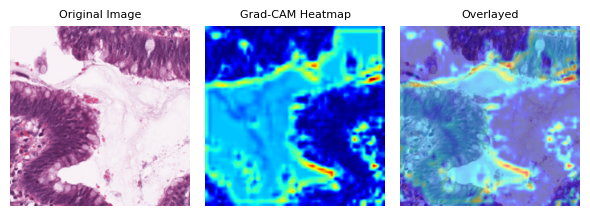

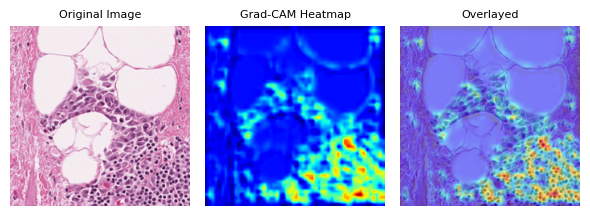

In [ ]:
for image_path in image_list:
    visualize_gradcam(cnn, gradcam_cnn, image_path, transform)

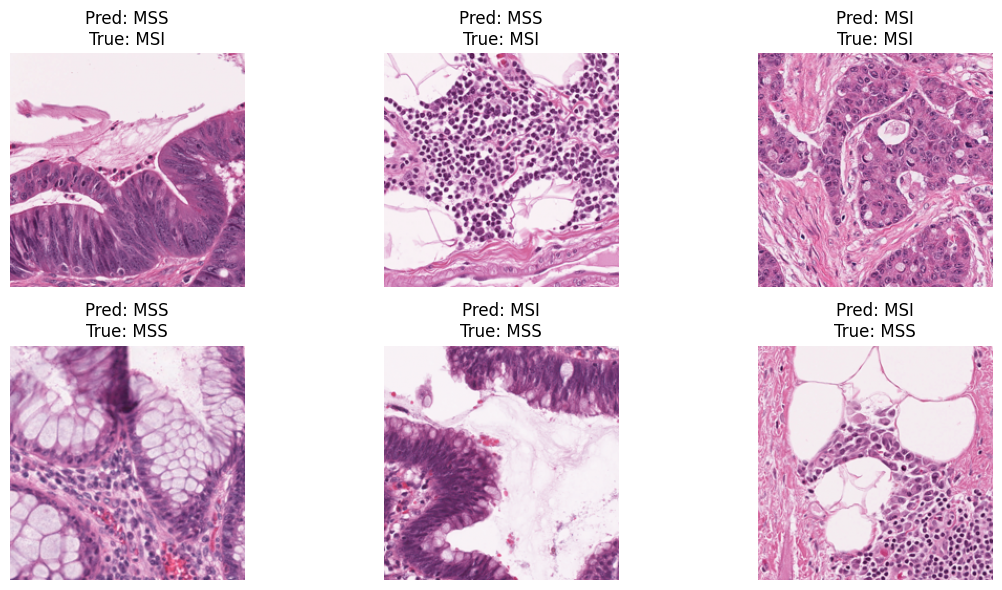

In [ ]:
visualize_list(cnn, image_list, transform, num_images=6)

## CNN with Self-Attention

In [ ]:
# Define the Self-Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling parameter

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate Query, Key, and Value
        query = self.query_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # (B, N, H*W)
        key = self.key_conv(x).view(batch_size, -1, height * width)  # (B, N, H*W)
        value = self.value_conv(x).view(batch_size, -1, height * width)  # (B, C, H*W)

        # Attention matrix (Dot product between Query and Key)
        attention = torch.bmm(query, key)  # (B, H*W, H*W)
        attention = F.softmax(attention, dim=-1)  # Softmax along the last axis

        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(batch_size, channels, height, width)  # Reshape back to original dimensions

        # Output with scaling factor
        out = (self.gamma * out) + x

        return out

# Define the CNN model class with Self-Attention
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()

        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Self-attention block
        self.attention = SelfAttention(128)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation, Batch Normalization, and pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        # Apply the self-attention mechanism
        x = self.attention(x)

        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 28 * 28)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
cnn_A = CNNWithSelfAttention()

# Move model to the GPU if available
cnn_A = cnn_A.to(device)

In [ ]:
optimizer_cnn_A = optim.Adam(cnn_A.parameters(), lr=0.0001, weight_decay= 0.0001)

In [ ]:
torch.nn.utils.clip_grad_norm_(cnn_A.parameters(), max_norm=1)

tensor(0.)


Epoch 1/25
__________
Epoch [1/25], Loss: 0.7472, Accuracy: 53.99%, Time: 0:03:32.919470
Validation Loss: 0.6670, Validation Accuracy: 59.80%

Epoch 2/25
__________
Epoch [2/25], Loss: 0.6543, Accuracy: 61.28%, Time: 0:03:25.203715
Validation Loss: 0.6357, Validation Accuracy: 64.82%

Epoch 3/25
__________
Epoch [3/25], Loss: 0.6214, Accuracy: 65.25%, Time: 0:03:26.202003
Validation Loss: 0.6008, Validation Accuracy: 67.74%

Epoch 4/25
__________
Epoch [4/25], Loss: 0.5865, Accuracy: 68.94%, Time: 0:03:25.613514
Validation Loss: 0.5985, Validation Accuracy: 67.63%

Epoch 5/25
__________
Epoch [5/25], Loss: 0.5516, Accuracy: 71.66%, Time: 0:03:25.230230
Validation Loss: 0.5558, Validation Accuracy: 71.47%

Epoch 6/25
__________
Epoch [6/25], Loss: 0.5213, Accuracy: 74.17%, Time: 0:03:25.034019
Validation Loss: 0.5389, Validation Accuracy: 72.68%

Epoch 7/25
__________
Epoch [7/25], Loss: 0.4865, Accuracy: 76.52%, Time: 0:03:25.091150
Validation Loss: 0.5509, Validation Accuracy: 71.98%

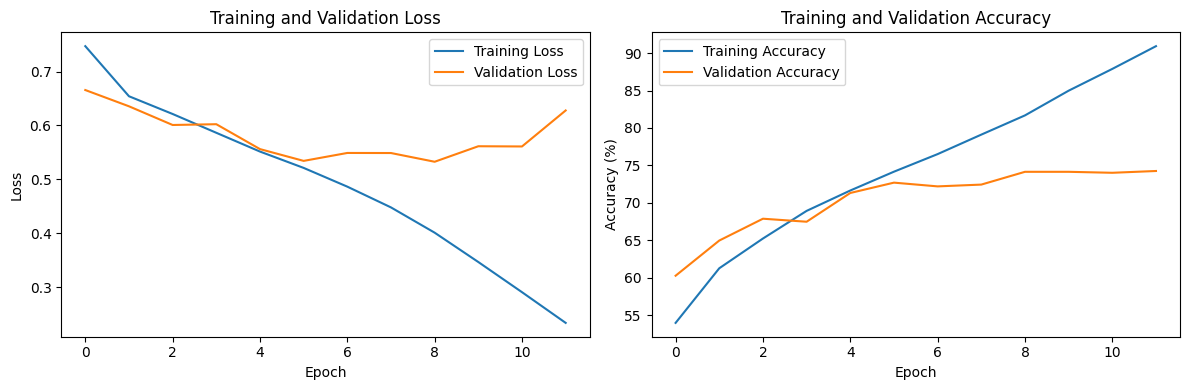

In [ ]:
# Train the model
train_model(cnn_A, train_loader, val_loader, criterion, optimizer_cnn_A, num_epochs=25)

### Evaluations - CNNWithSelfAttention

In [ ]:
# Evaluate the model
y_pred2, y_true2 = evaluate_test(cnn_A, test_loader)

Test Accuracy: 73.92%



Classification Report:
              precision    recall  f1-score   support

         MSI       0.75      0.73      0.74      4600
         MSS       0.73      0.75      0.74      4600

    accuracy                           0.74      9200
   macro avg       0.74      0.74      0.74      9200
weighted avg       0.74      0.74      0.74      9200



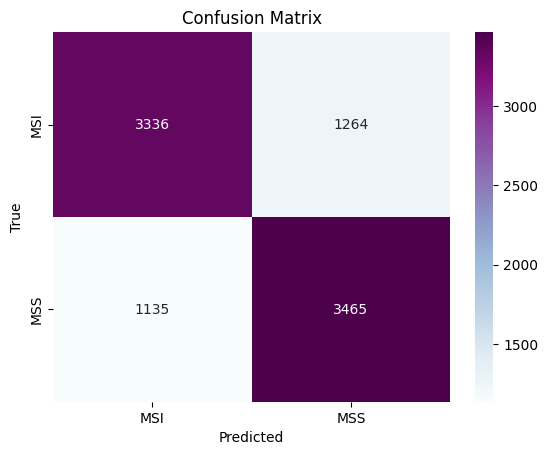

In [ ]:
# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true2, y_pred2, target_names=test_data.classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true2, y_pred2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print (f'PPV= {3336/(3336 + 1135)}')

PPV= 0.746141802728696


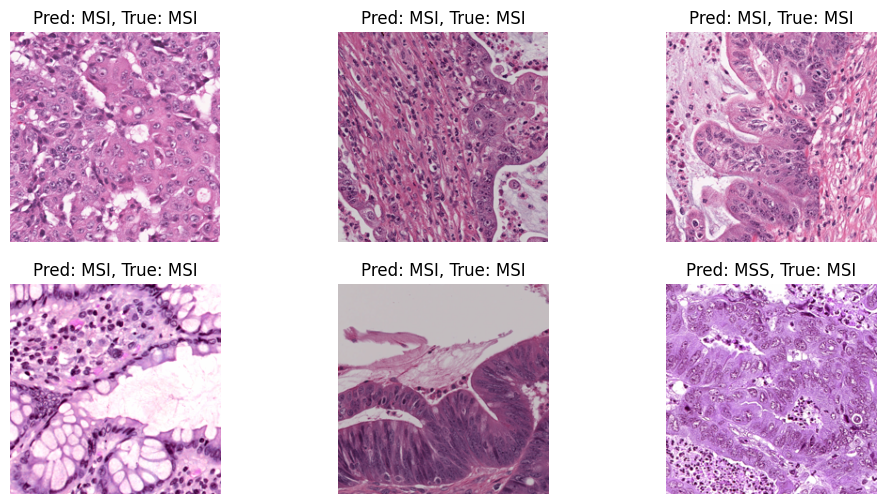

In [ ]:
# Visualize predictions
visualize_predictions(cnn_A, test_loader)

Test Accuracy: 73.95%


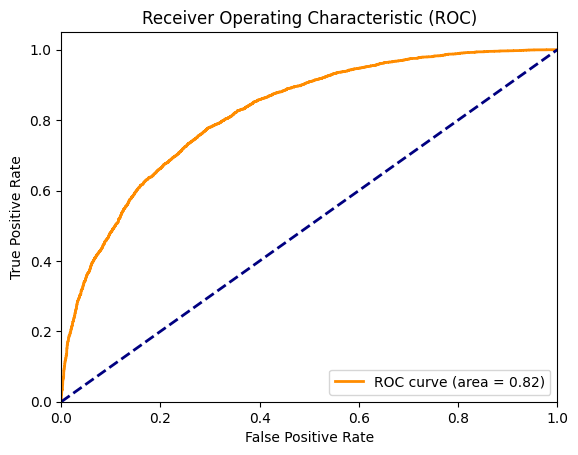

In [ ]:
evaluate_model_and_plot_roc(cnn_A, test_loader)

In [ ]:
count_parameters(cnn_A)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 0.58 Giga FLOPs
Total Number of Parameters: 51.50 million
Trainable Number of Parameters: 51.50 million


## CNN Attention Only

In [ ]:
# Define the Self-Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling parameter

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate Query, Key, and Value
        query = self.query_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # (B, N, H*W)
        key = self.key_conv(x).view(batch_size, -1, height * width)  # (B, N, H*W)
        value = self.value_conv(x).view(batch_size, -1, height * width)  # (B, C, H*W)

        # Attention matrix (Dot product between Query and Key)
        attention = torch.bmm(query, key)  # (B, H*W, H*W)
        attention = F.softmax(attention, dim=-1)  # Softmax along the last axis

        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(batch_size, channels, height, width)  # Reshape back to original dimensions

        # Output with scaling factor
        out = self.gamma * out # The residual connection here before (plus x) has been removed

        return out

# Define the CNN model class with Self-Attention
class CNNAttentionOnly(nn.Module):
    def __init__(self):
        super(CNNAttentionOnly, self).__init__()

        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Self-attention block
        self.attention = SelfAttention(128)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation, Batch Normalization, and pooling
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        # Apply the self-attention mechanism
        x = self.attention(x)

        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 28 * 28)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
cnn_A2 = CNNAttentionOnly()

# Move model to the GPU if available
cnn_A2 = cnn_A2.to(device)

In [ ]:
optimizer_cnn_A2 = optim.Adam(cnn_A2.parameters(), lr=0.0001, weight_decay= 0.0001)

In [ ]:
torch.nn.utils.clip_grad_norm_(cnn_A2.parameters(), max_norm=1)

tensor(0.)


Epoch 1/25
__________
Epoch [1/25], Loss: 0.6636, Accuracy: 59.50%, Time: 0:03:31.602740
Validation Loss: 0.6374, Validation Accuracy: 63.84%

Epoch 2/25
__________
Epoch [2/25], Loss: 0.6164, Accuracy: 66.45%, Time: 0:03:24.649105
Validation Loss: 0.5988, Validation Accuracy: 68.62%

Epoch 3/25
__________
Epoch [3/25], Loss: 0.5786, Accuracy: 69.80%, Time: 0:03:24.628182
Validation Loss: 0.5651, Validation Accuracy: 70.90%

Epoch 4/25
__________
Epoch [4/25], Loss: 0.5524, Accuracy: 71.88%, Time: 0:03:24.524957
Validation Loss: 0.5457, Validation Accuracy: 71.85%

Epoch 5/25
__________
Epoch [5/25], Loss: 0.5229, Accuracy: 74.04%, Time: 0:03:25.725771
Validation Loss: 0.5127, Validation Accuracy: 74.61%

Epoch 6/25
__________
Epoch [6/25], Loss: 0.4976, Accuracy: 75.70%, Time: 0:03:24.988223
Validation Loss: 0.5021, Validation Accuracy: 76.04%

Epoch 7/25
__________
Epoch [7/25], Loss: 0.4768, Accuracy: 77.13%, Time: 0:03:24.681486
Validation Loss: 0.4598, Validation Accuracy: 78.01%

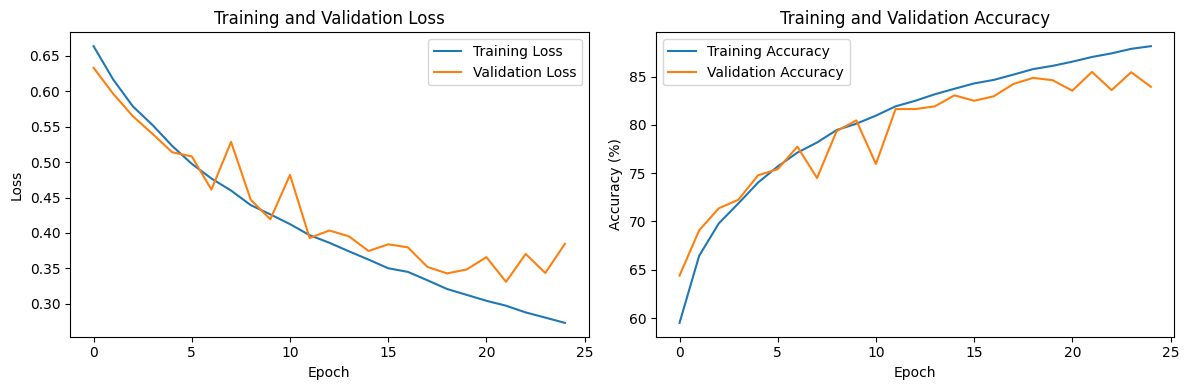

In [ ]:
# Train the model
train_model(cnn_A2, train_loader, val_loader, criterion, optimizer_cnn_A2, num_epochs=25)

### Evaluations - CNNAttentionOnly

In [ ]:
# Evaluate the model
y_pred3, y_true3 = evaluate_test(cnn_A2, test_loader)

Test Accuracy: 83.23%



Classification Report:
              precision    recall  f1-score   support

         MSI       0.79      0.91      0.85      4600
         MSS       0.90      0.75      0.82      4600

    accuracy                           0.83      9200
   macro avg       0.84      0.83      0.83      9200
weighted avg       0.84      0.83      0.83      9200



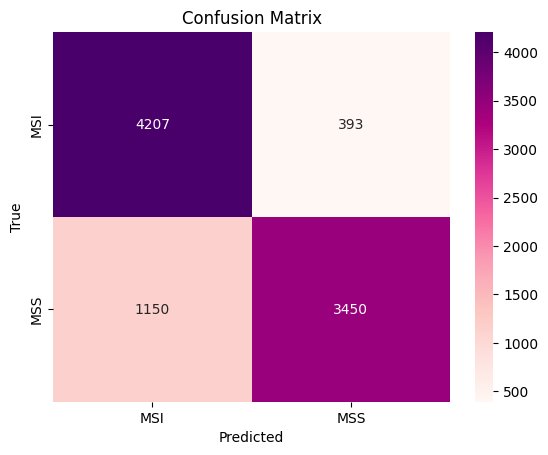

In [ ]:

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true3, y_pred3, target_names=test_data.classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true3, y_pred3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print (f'PPV= {4207/(4207 + 1150)}')

PPV= 0.785327608736233


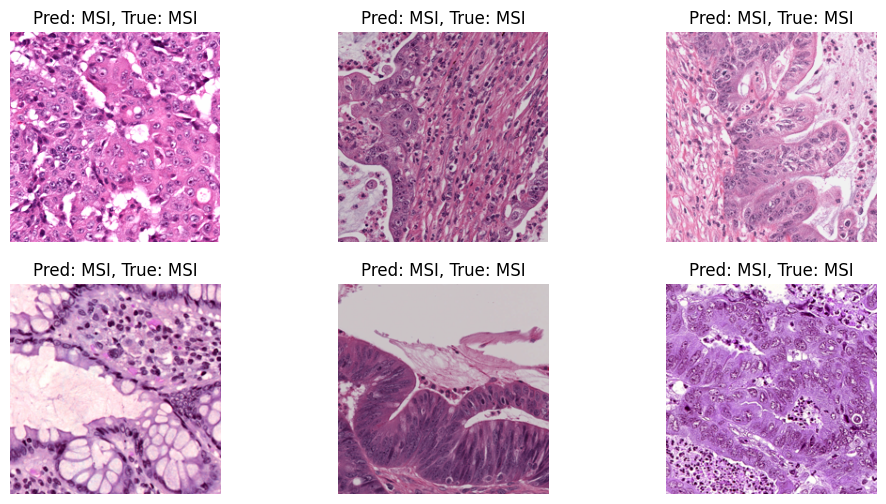

In [ ]:
# Visualize predictions
visualize_predictions(cnn_A2, test_loader)

Test Accuracy: 83.01%


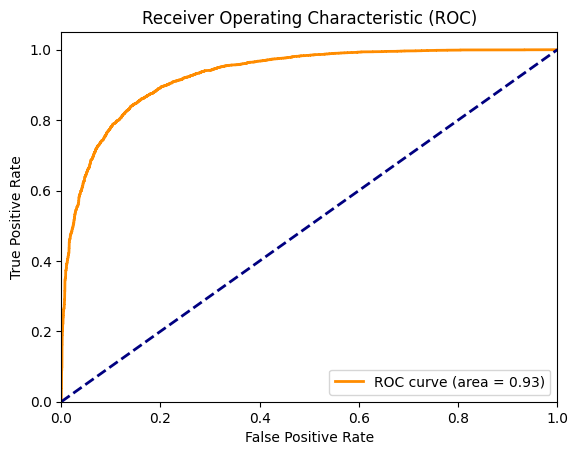

In [ ]:
evaluate_model_and_plot_roc(cnn_A2, test_loader)

In [ ]:
count_parameters(cnn_A2)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 0.58 Giga FLOPs
Total Number of Parameters: 51.50 million
Trainable Number of Parameters: 51.50 million


In [ ]:
epoch_cnn_A2 = 25
loss_cnn_A2 = 0.2731

In [ ]:
save_checkpoint(cnn_A2, optimizer_cnn_A2, epoch_cnn_A2, loss_cnn_A2, path="checkpoint_cnn_A2.pth")

Checkpoint saved to: checkpoint_cnn_A2.pth


### GradCAM - CNNAttentionOnly

In [ ]:
gradcam_cnn_A2= GradCAM(cnn_A2, cnn_A2.attention)

C:\Users\olubo\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


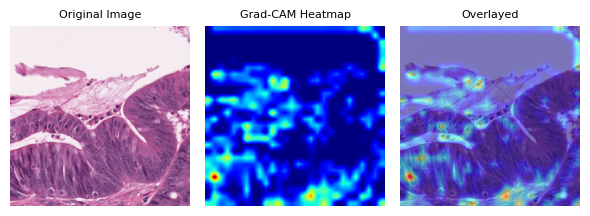

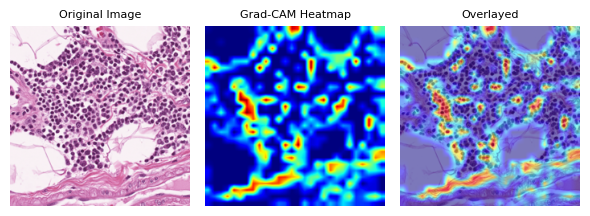

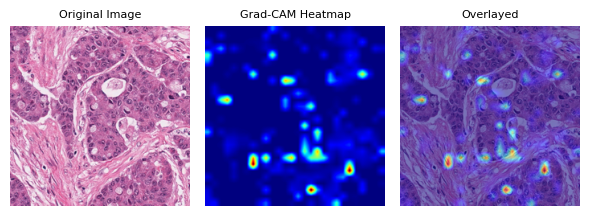

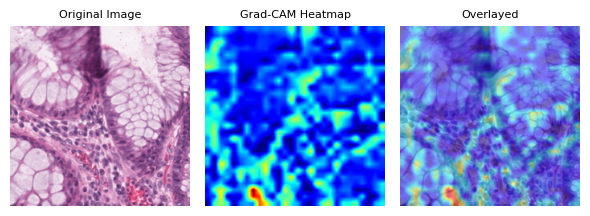

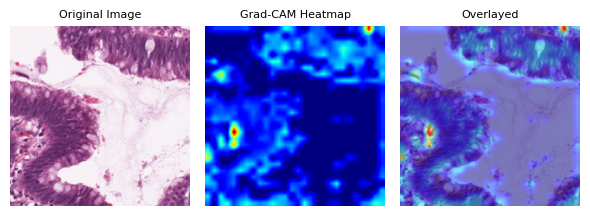

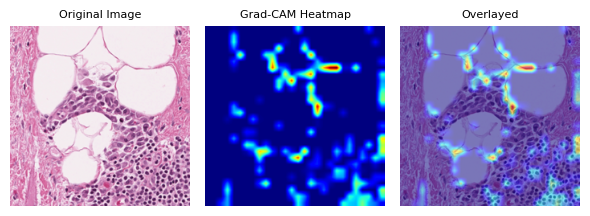

In [ ]:
for image_path in image_list:
    visualize_gradcam(cnn_A2, gradcam_cnn_A2, image_path, transform)

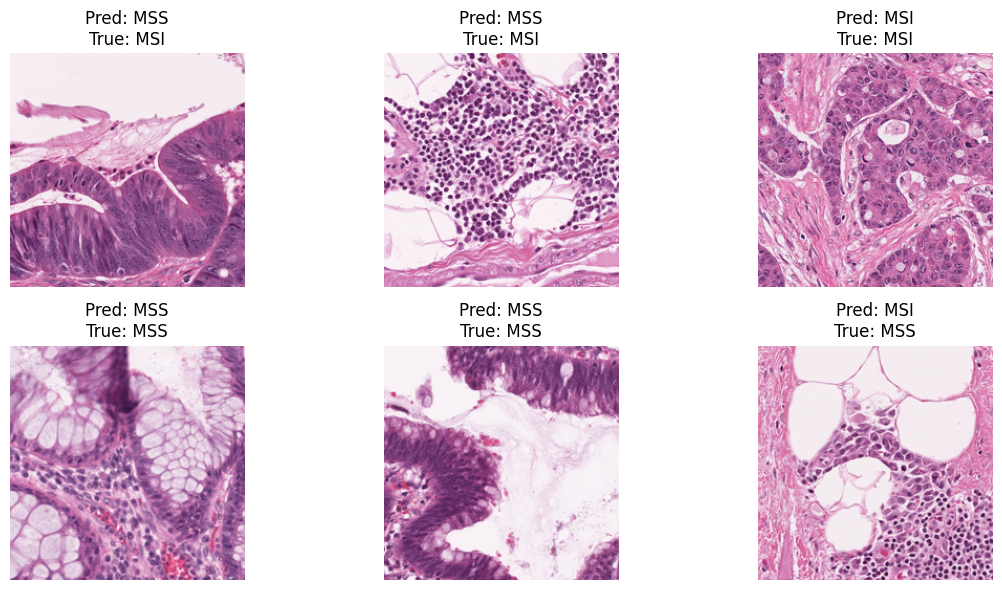

In [ ]:
visualize_list(cnn_A2, image_list, transform, num_images=6)

In [ ]:
torch.cuda.empty_cache()